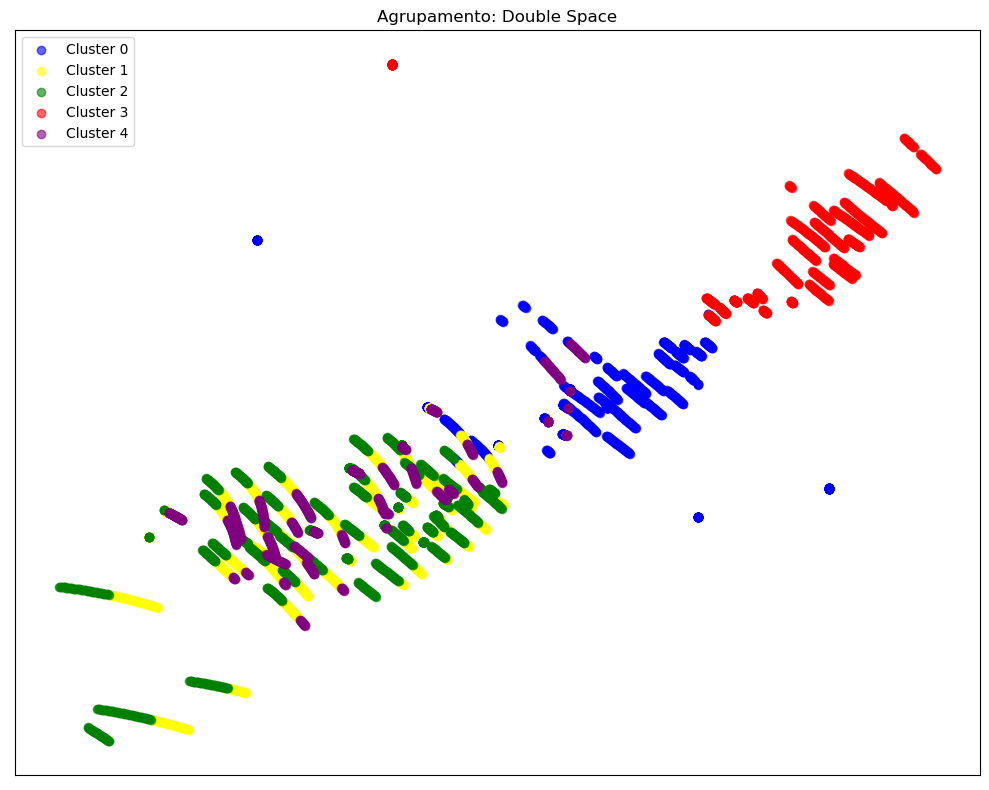

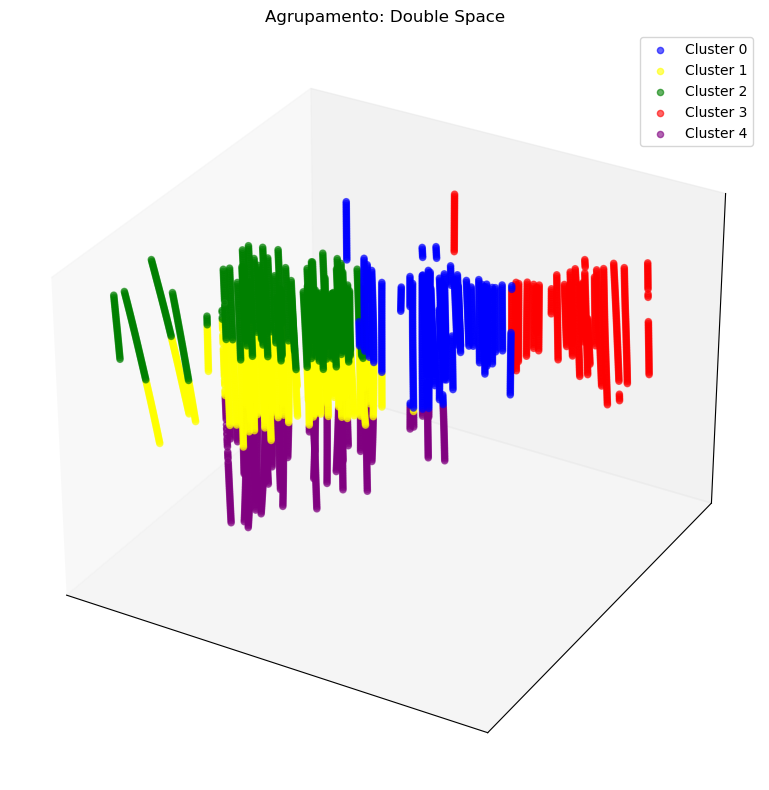

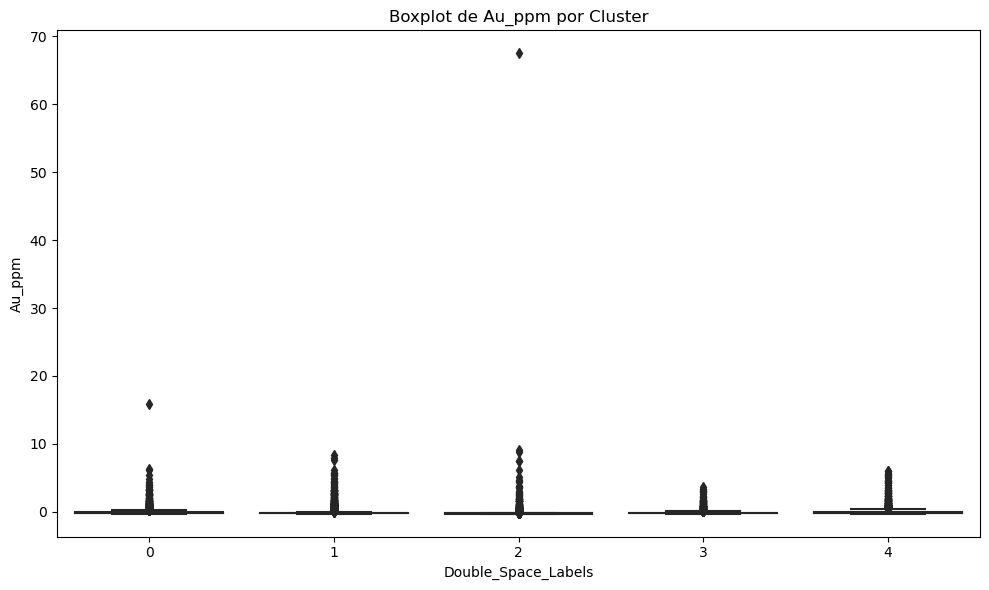

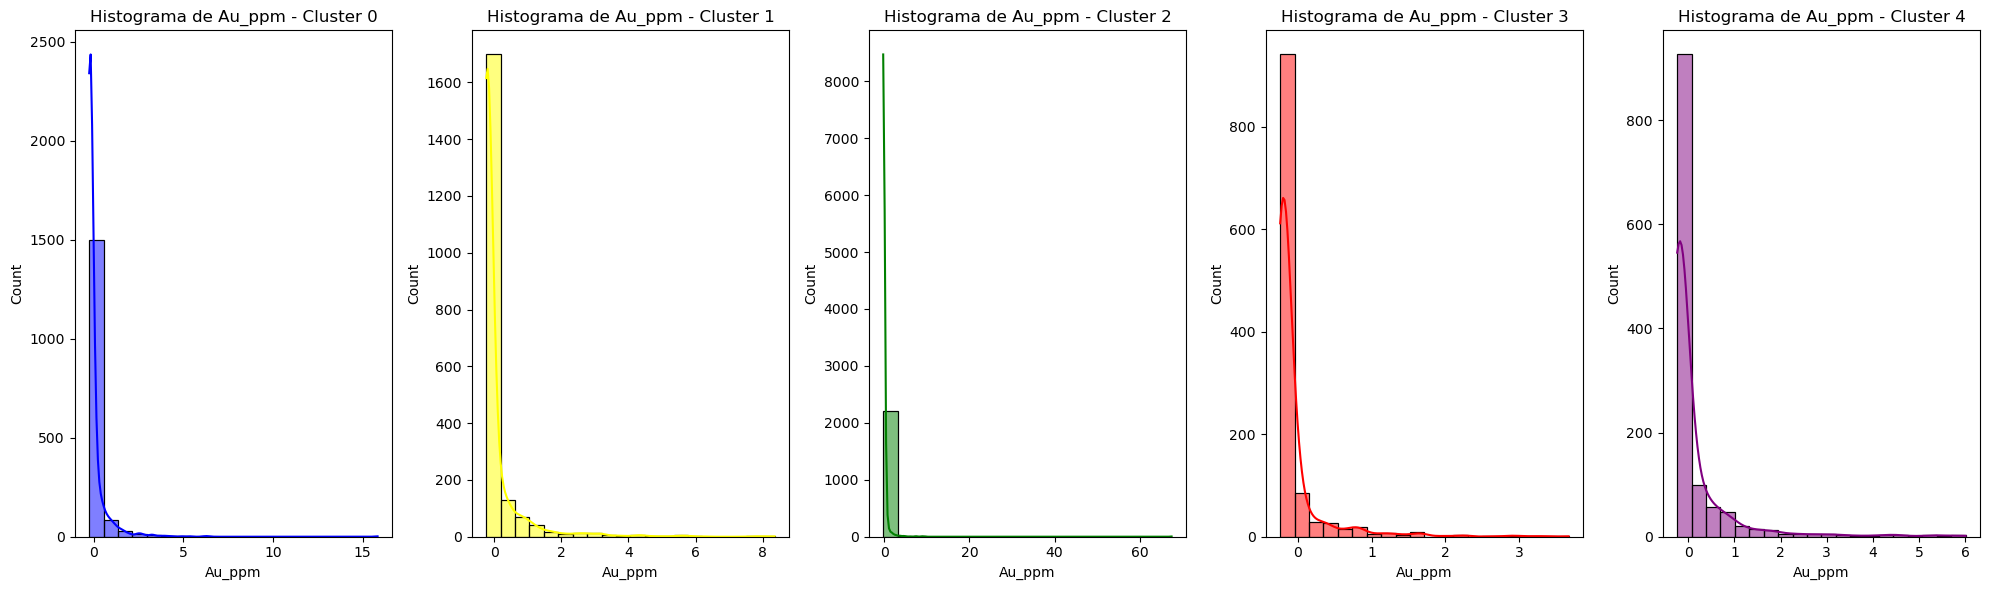

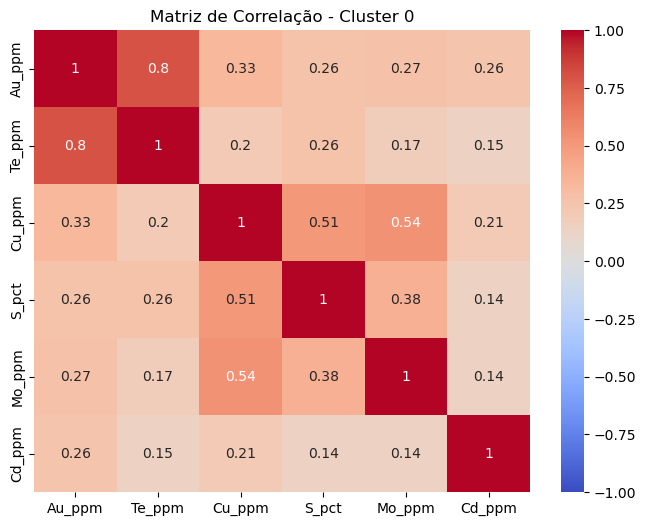

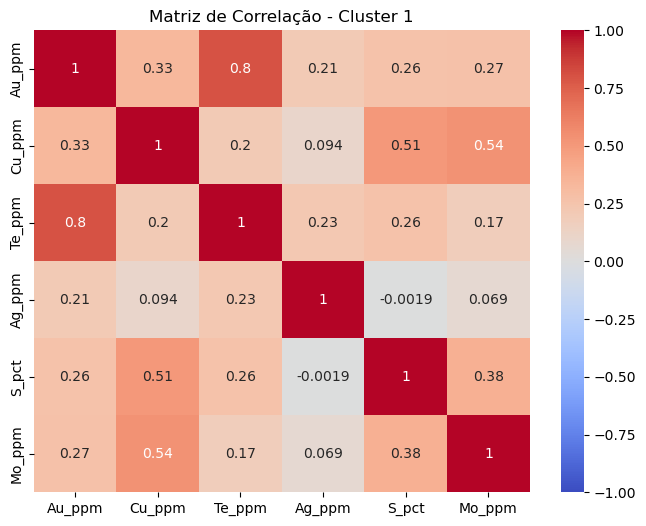

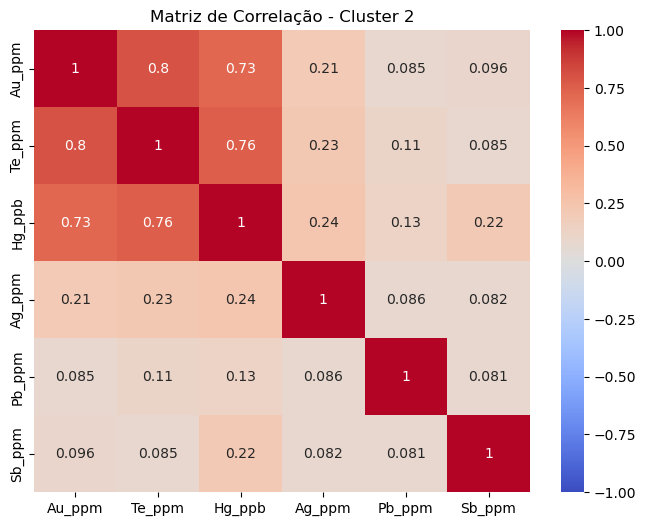

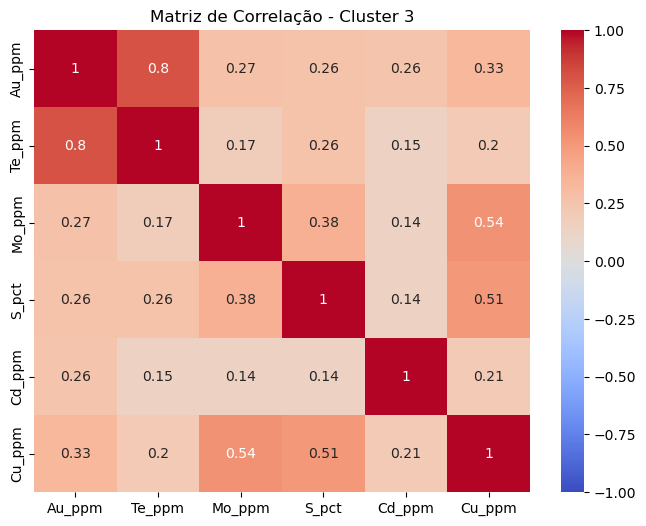

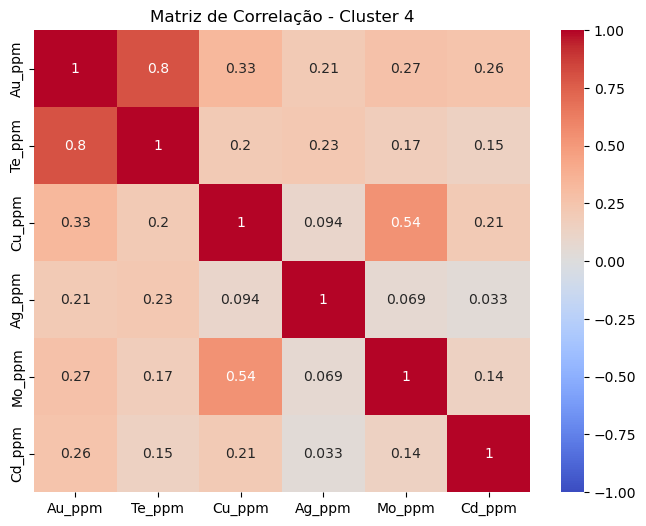

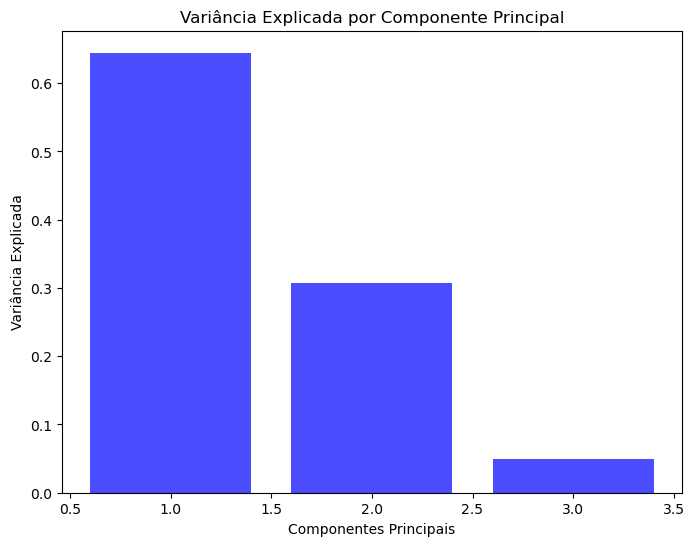

Resultados dos métodos de agrupamento:

Double Space:
Silhouette: 0.37529697159905645
Davies-Bouldin: 0.9110725001793991
Calinski-Harabasz: 8513.577134488854
WCSS: 4593.291715548336
Entropy: 36.250085107327735

Melhor método de agrupamento: Double Space
Dataset com valores de agrupamento salvo em: D:\python\hochschild\COMPOSITE_2_5_NORMALIZADO_with_clusters_Iso.csv
Scores de avaliação salvos em: D:\python\hochschild\clustering_evaluation_scores_Iso.csv


In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.spatial.distance import cdist
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Carregar o dataset
file_path = r'D:\python\hochschild\COMPOSITE_2_5_normalizado_Iso.csv'
data = pd.read_csv(file_path)

# Verificar se a coluna 'Au_ppm' está presente
if 'Au_ppm' not in data.columns:
    raise KeyError("A coluna 'Au_ppm' não está presente no DataFrame.")

# Selecionar as variáveis numéricas e as coordenadas
X = data[['mid_x', 'mid_y', 'mid_z']]

# Pré-processamento
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Função para calcular WCSS
def calculate_wcss(data, labels):
    clusters = np.unique(labels)
    wcss = 0
    for cluster in clusters:
        cluster_points = data[labels == cluster]
        centroid = cluster_points.mean(axis=0)
        wcss += np.sum((cluster_points - centroid) ** 2)
    return wcss

# Função para calcular a entropia espacial
def calculate_entropy(data, labels):
    clusters = np.unique(labels)
    entropy = 0
    for cluster in clusters:
        cluster_points = data[labels == cluster]
        centroid = cluster_points.mean(axis=0)
        cluster_size = len(cluster_points)
        if cluster_size > 1:
            distances = cdist(cluster_points, [centroid], 'euclidean')
            probabilities = distances / np.sum(distances)
            entropy -= np.sum(probabilities * np.log(probabilities))
    return entropy

# Dicionário para armazenar os resultados
results = {}

# Agrupamento em Espaço Duplo (Exemplo Simples)
# Aqui, vamos usar K-Means em um espaço transformado como exemplo
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
double_space_kmeans = KMeans(n_clusters=5, random_state=42)
double_space_labels = double_space_kmeans.fit_predict(X_pca)

results['Double Space'] = {
    'Silhouette': silhouette_score(X_pca, double_space_labels),
    'Davies-Bouldin': davies_bouldin_score(X_pca, double_space_labels),
    'Calinski-Harabasz': calinski_harabasz_score(X_pca, double_space_labels),
    'WCSS': calculate_wcss(X_pca, double_space_labels),
    'Entropy': calculate_entropy(X_pca, double_space_labels)
}
data['Double_Space_Labels'] = double_space_labels

# Exportar o dataset com os valores de agrupamento
output_file_path = os.path.join(os.path.dirname(file_path), 'COMPOSITE_2_5_NORMALIZADO_with_clusters_Iso.csv')
data.to_csv(output_file_path, index=False)

# Exportar os scores de avaliação
scores_df = pd.DataFrame(results).T
scores_file_path = os.path.join(os.path.dirname(file_path), 'clustering_evaluation_scores_Iso.csv')
scores_df.to_csv(scores_file_path)

# Plotar os agrupamentos em gráficos 2D usando mid_x e mid_y
colors = ['blue', 'yellow', 'green', 'red', 'purple']
fig, ax = plt.subplots(figsize=(10, 8))

labels = data['Double_Space_Labels']
for label in np.unique(labels):
    ax.scatter(data['mid_x'][labels == label], data['mid_y'][labels == label], c=colors[label], label=f'Cluster {label}', alpha=0.6)
ax.set_title('Agrupamento: Double Space')
ax.legend()
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()

# Plotar os agrupamentos em gráficos 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for label in np.unique(labels):
    ax.scatter(data['mid_x'][labels == label], data['mid_y'][labels == label], data['mid_z'][labels == label], c=colors[label], label=f'Cluster {label}', alpha=0.6)
ax.set_title('Agrupamento: Double Space')
ax.legend()
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

plt.tight_layout()
plt.show()

# Boxplots para Au_ppm em cada cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x='Double_Space_Labels', y='Au_ppm', data=data, palette=colors)
plt.title('Boxplot de Au_ppm por Cluster')
plt.tight_layout()
plt.show()

# Histogramas para Au_ppm em cada cluster
fig, axes = plt.subplots(1, 5, figsize=(20, 6))
for label in np.unique(labels):
    sns.histplot(data[data['Double_Space_Labels'] == label]['Au_ppm'], bins=20, ax=axes[label], color=colors[label], kde=True)
    axes[label].set_title(f'Histograma de Au_ppm - Cluster {label}')

plt.tight_layout()
plt.show()

# Matriz de correlação para cada cluster considerando as cinco melhores correlações positivas com Au_ppm
variables = data.columns.drop(['Double_Space_Labels'])
for label in np.unique(labels):
    cluster_data = data[data['Double_Space_Labels'] == label][variables]
    corr = cluster_data.corr()
    top_corr = corr['Au_ppm'].sort_values(ascending=False).head(6).index  # Inclui Au_ppm e as cinco melhores correlações
    top_corr_data = data[top_corr]
    top_corr_matrix = top_corr_data.corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Matriz de Correlação - Cluster {label}')
    plt.show()

# Análise de Componentes Principais (PCA)
pca = PCA(n_components=3)
pca.fit(X_scaled)
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(8, 6))
plt.bar(range(1, 4), explained_variance, alpha=0.7, align='center', color='blue')
plt.xlabel('Componentes Principais')
plt.ylabel('Variância Explicada')
plt.title('Variância Explicada por Componente Principal')
plt.show()

print("Resultados dos métodos de agrupamento:")
for method, scores in results.items():
    print(f"\n{method}:")
    for metric, score in scores.items():
        print(f"{metric}: {score}")

print(f"\nMelhor método de agrupamento: Double Space")
print(f"Dataset com valores de agrupamento salvo em: {output_file_path}")
print(f"Scores de avaliação salvos em: {scores_file_path}")



